# Predicting S&P 500 Price for the coming year

In [179]:
# import 
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from pathlib import Path
import hvplot.pandas
import datetime as dt
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import requests
import json
from alpaca_trade_api.rest import REST, TimeFrame
from dotenv import load_dotenv


%matplotlib inline


In [180]:
# load environment 
load_dotenv()

True

### Set up Alpaca Trade API

In [181]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
print(type(alpaca_api_key))

<class 'str'>


In [182]:
# load Alpaca API REST object
alpaca = REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [183]:
# use get bars to pull from api from 2015-2023
ticker = "GOOG"
goog_df = alpaca.get_bars(f"{ticker}", TimeFrame.Hour, "2022-07-18", "2023-02-05", adjustment='raw').df



In [184]:
# display data
goog_df.index = goog_df.index.tz_localize(None)
goog_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-07-18 08:00:00,114.25,114.4000,113.72,114.23,16547,301,114.102614
2022-07-18 09:00:00,114.23,114.5200,114.17,114.40,14282,320,114.329392
2022-07-18 10:00:00,114.38,114.7500,114.25,114.45,17148,297,114.476918
2022-07-18 11:00:00,114.44,114.7100,114.16,114.55,173730,2663,114.539386
2022-07-18 12:00:00,114.59,114.6300,113.38,114.06,345753,8312,113.919702
...,...,...,...,...,...,...,...
2023-02-03 20:00:00,104.60,105.5600,104.44,105.21,4575327,50831,105.122087
2023-02-03 21:00:00,105.20,105.4900,105.14,105.42,3724639,788,105.221107
2023-02-03 22:00:00,105.22,105.4133,105.22,105.32,59865,130,105.240961


In [185]:
# format data for prophet
columns = ['close']
prophet_df = goog_df[columns]
prophet_df = prophet_df

In [186]:
# Display closing price of AAPL
prophet_df.hvplot.line(
    y = 'close',
    label = 'GOOG closing price from 2022-2023 After Stock Split'
    
)

:Curve   [timestamp]   (close)

### Format DataFrame for Prophet

In [187]:
# Use helper code to format df for prophet model
from helper_code import Helper
helper = Helper()
format_prophet_df = helper.prophet_format(prophet_df)



In [188]:
# Load prophet model
prophet = Prophet()
prophet

In [189]:
# Fit data
prophet.fit(format_prophet_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [190]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as six months (6 months = ~182.5 days = 4,380 hours)
future_trends = prophet.make_future_dataframe(periods=4380, freq='H')

# View the first and last five rows of the future dataframe
display(future_trends.head())
display(future_trends.tail())

,ds
0,2022-07-18 08:00:00
1,2022-07-18 09:00:00
2,2022-07-18 10:00:00
3,2022-07-18 11:00:00
4,2022-07-18 12:00:00


,ds
6613,2023-08-05 08:00:00
6614,2023-08-05 09:00:00
6615,2023-08-05 10:00:00
6616,2023-08-05 11:00:00
6617,2023-08-05 12:00:00


In [191]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = prophet.predict(future_trends)

# Display the first five rows of the forecast DataFrame
forecast_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-18 08:00:00,112.212550,109.360149,114.936792,112.212550,112.212550,-0.021590,-0.021590,-0.021590,0.113380,0.113380,0.113380,-0.134970,-0.134970,-0.134970,0.0,0.0,0.0,112.190960
1,2022-07-18 09:00:00,112.209982,109.367902,115.146980,112.209982,112.209982,0.044091,0.044091,0.044091,0.179153,0.179153,0.179153,-0.135062,-0.135062,-0.135062,0.0,0.0,0.0,112.254072
2,2022-07-18 10:00:00,112.207413,109.261593,115.108917,112.207413,112.207413,0.017906,0.017906,0.017906,0.151101,0.151101,0.151101,-0.133194,-0.133194,-0.133194,0.0,0.0,0.0,112.225319
3,2022-07-18 11:00:00,112.204844,109.384879,114.910139,112.204844,112.204844,-0.014195,-0.014195,-0.014195,0.115420,0.115420,0.115420,-0.129615,-0.129615,-0.129615,0.0,0.0,0.0,112.190649
4,2022-07-18 12:00:00,112.202275,109.383757,115.099324,112.202275,112.202275,-0.001920,-0.001920,-0.001920,0.122668,0.122668,0.122668,-0.124588,-0.124588,-0.124588,0.0,0.0,0.0,112.200356


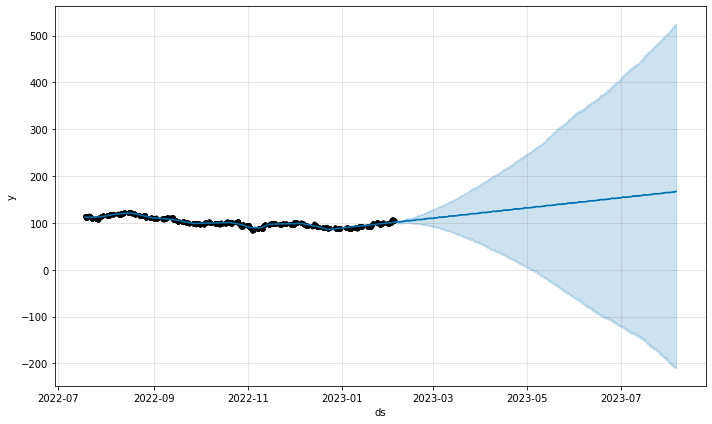

In [192]:
# Plot the Prophet predictions for the forecast_trends data
prophet.plot(forecast_trends);

### Convert historical data into price adjusted stock split for AAPL

In [193]:
# Grab older data from Alpaca
ticker = "GOOG"
old_goog_df = alpaca.get_bars(f"{ticker}", TimeFrame.Hour, "2015-07-18", "2023-02-05", adjustment='raw').df
old_goog_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2015-12-01 09:00:00+00:00,746.00,746.0000,746.00,746.00,138,1,746.000000
2015-12-01 11:00:00+00:00,745.50,745.5000,745.50,745.50,312,4,745.500000
2015-12-01 13:00:00+00:00,745.89,746.8500,745.89,746.00,2639,25,746.029197
2015-12-01 14:00:00+00:00,747.00,760.5000,746.30,760.35,376881,5237,753.975424
2015-12-01 15:00:00+00:00,759.72,762.6800,757.91,761.40,426089,6917,759.683375
...,...,...,...,...,...,...,...
2023-02-03 20:00:00+00:00,104.60,105.5600,104.44,105.21,4575327,50831,105.122087
2023-02-03 21:00:00+00:00,105.20,105.4900,105.14,105.42,3724639,788,105.221107
2023-02-03 22:00:00+00:00,105.22,105.4133,105.22,105.32,59865,130,105.240961


In [194]:
# Remove timezone 
old_goog_df.index = old_goog_df.index.tz_convert(None)
old_goog_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2015-12-01 09:00:00,746.00,746.0000,746.00,746.00,138,1,746.000000
2015-12-01 11:00:00,745.50,745.5000,745.50,745.50,312,4,745.500000
2015-12-01 13:00:00,745.89,746.8500,745.89,746.00,2639,25,746.029197
2015-12-01 14:00:00,747.00,760.5000,746.30,760.35,376881,5237,753.975424
2015-12-01 15:00:00,759.72,762.6800,757.91,761.40,426089,6917,759.683375
...,...,...,...,...,...,...,...
2023-02-03 20:00:00,104.60,105.5600,104.44,105.21,4575327,50831,105.122087
2023-02-03 21:00:00,105.20,105.4900,105.14,105.42,3724639,788,105.221107
2023-02-03 22:00:00,105.22,105.4133,105.22,105.32,59865,130,105.240961


In [195]:
# grab closing prices
old_prophet_df = old_goog_df['close']
old_prophet_df

timestamp
2015-12-01 09:00:00    746.00
2015-12-01 11:00:00    745.50
2015-12-01 13:00:00    746.00
2015-12-01 14:00:00    760.35
2015-12-01 15:00:00    761.40
                        ...  
2023-02-03 20:00:00    105.21
2023-02-03 21:00:00    105.42
2023-02-03 22:00:00    105.32
2023-02-03 23:00:00    105.02
2023-02-04 00:00:00    105.20
Name: close, Length: 21803, dtype: float64

In [196]:
# plot closing prices
old_prophet_df.hvplot.line()

:Curve   [timestamp]   (close)

In [197]:
# split dataframe from (2017-07-20,2022-07-15) and (2022-07-18, 2023-02-05)
# google went for a 20-1 stock split in mid July - Source https://www.cnbc.com/2022/02/01/google-parent-alphabet-announces-20-for-1-stock-split.html

pre_split_df = old_prophet_df.loc['2017-07-20': '2022-07-15']
post_split_df = old_prophet_df.loc['2022-07-18': '2023-02-05']

display(pre_split_df.tail())
display(post_split_df.head())


timestamp
2022-07-15 18:00:00    2246.33
2022-07-15 19:00:00    2255.33
2022-07-15 20:00:00    2254.00
2022-07-15 21:00:00    2256.00
2022-07-15 23:00:00    2259.50
Name: close, dtype: float64

timestamp
2022-07-18 08:00:00    114.23
2022-07-18 09:00:00    114.40
2022-07-18 10:00:00    114.45
2022-07-18 11:00:00    114.55
2022-07-18 12:00:00    114.06
Name: close, dtype: float64

In [198]:
# Adjust prices by dividing by 20 for all closing prices of pre split values
pre_split_df = pre_split_df / 20
pre_split_df.tail()

timestamp
2022-07-15 18:00:00    112.3165
2022-07-15 19:00:00    112.7665
2022-07-15 20:00:00    112.7000
2022-07-15 21:00:00    112.8000
2022-07-15 23:00:00    112.9750
Name: close, dtype: float64

In [199]:
# Split stock data from stock split for AAPL
pre_split_df.hvplot(label="Google closing price adjusted for split",
                    ylabel='close')

:Curve   [timestamp]   (close)

In [200]:
# combine dataframes
combined_split_df = pd.concat([pre_split_df, post_split_df], axis=0)
combined_split_df

timestamp
2017-07-20 11:00:00     48.65000
2017-07-20 12:00:00     48.65000
2017-07-20 13:00:00     48.74525
2017-07-20 14:00:00     48.62400
2017-07-20 15:00:00     48.47550
                         ...    
2023-02-03 20:00:00    105.21000
2023-02-03 21:00:00    105.42000
2023-02-03 22:00:00    105.32000
2023-02-03 23:00:00    105.02000
2023-02-04 00:00:00    105.20000
Name: close, Length: 17132, dtype: float64

In [201]:
# plot to check 
combined_split_df.hvplot(label='Goog Closing Price adjusted for stock split 2017-2023')

:Curve   [timestamp]   (close)

In [202]:
# reformat dataframe for prophet use
combined_split_df = combined_split_df.reset_index()
combined_split_df

,timestamp,close
0,2017-07-20 11:00:00,48.65000
1,2017-07-20 12:00:00,48.65000
2,2017-07-20 13:00:00,48.74525
3,2017-07-20 14:00:00,48.62400
4,2017-07-20 15:00:00,48.47550
...,...,...
17127,2023-02-03 20:00:00,105.21000
17128,2023-02-03 21:00:00,105.42000
17129,2023-02-03 22:00:00,105.32000
17130,2023-02-03 23:00:00,105.02000


In [203]:
# rename columns
columns=['ds', 'y']
combined_split_df.columns = columns
combined_split_df

,ds,y
0,2017-07-20 11:00:00,48.65000
1,2017-07-20 12:00:00,48.65000
2,2017-07-20 13:00:00,48.74525
3,2017-07-20 14:00:00,48.62400
4,2017-07-20 15:00:00,48.47550
...,...,...
17127,2023-02-03 20:00:00,105.21000
17128,2023-02-03 21:00:00,105.42000
17129,2023-02-03 22:00:00,105.32000
17130,2023-02-03 23:00:00,105.02000


In [204]:
# call new prophet
prophet_two = Prophet()

# fit the data
prophet_two.fit(combined_split_df)

In [205]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as six months (6 months = ~182.5 days = 4,380 hours)
future_trends_two = prophet_two.make_future_dataframe(periods=4380, freq='H')

# View the first and last five rows of the future dataframe
display(future_trends_two.head())
display(future_trends_two.tail())

,ds
0,2017-07-20 11:00:00
1,2017-07-20 12:00:00
2,2017-07-20 13:00:00
3,2017-07-20 14:00:00
4,2017-07-20 15:00:00


,ds
21507,2023-08-05 08:00:00
21508,2023-08-05 09:00:00
21509,2023-08-05 10:00:00
21510,2023-08-05 11:00:00
21511,2023-08-05 12:00:00


In [208]:
# six month predictons
six_month_predictions = prophet_two.predict(future_trends_two)

In [210]:
# observe dataframe
six_month_predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-20 11:00:00,41.943411,39.143578,47.184620,41.943411,41.943411,1.290108,1.290108,1.290108,0.033033,...,0.076479,0.076479,0.076479,1.180596,1.180596,1.180596,0.0,0.0,0.0,43.233519
1,2017-07-20 12:00:00,41.948033,39.078030,47.479303,41.948033,41.948033,1.368768,1.368768,1.368768,0.102505,...,0.077017,0.077017,0.077017,1.189246,1.189246,1.189246,0.0,0.0,0.0,43.316801
2,2017-07-20 13:00:00,41.952656,39.081032,47.838448,41.952656,41.952656,1.436807,1.436807,1.436807,0.161594,...,0.077333,0.077333,0.077333,1.197880,1.197880,1.197880,0.0,0.0,0.0,43.389462
3,2017-07-20 14:00:00,41.957278,38.922205,47.730464,41.957278,41.957278,1.474892,1.474892,1.474892,0.190973,...,0.077422,0.077422,0.077422,1.206497,1.206497,1.206497,0.0,0.0,0.0,43.432170
4,2017-07-20 15:00:00,41.961900,38.989784,47.535420,41.961900,41.961900,1.479442,1.479442,1.479442,0.187066,...,0.077278,0.077278,0.077278,1.215098,1.215098,1.215098,0.0,0.0,0.0,43.441343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21507,2023-08-05 08:00:00,69.298889,35.548187,109.940803,32.897414,107.245078,2.687693,2.687693,2.687693,-0.245929,...,0.014952,0.014952,0.014952,2.918669,2.918669,2.918669,0.0,0.0,0.0,71.986582
21508,2023-08-05 09:00:00,69.294119,34.627579,110.520883,32.882896,107.255851,2.810734,2.810734,2.810734,-0.127865,...,0.018828,0.018828,0.018828,2.919772,2.919772,2.919772,0.0,0.0,0.0,72.104853
21509,2023-08-05 10:00:00,69.289350,36.869482,110.681962,32.868377,107.266624,2.904854,2.904854,2.904854,-0.039115,...,0.023106,0.023106,0.023106,2.920863,2.920863,2.920863,0.0,0.0,0.0,72.194203
21510,2023-08-05 11:00:00,69.284580,36.169272,110.996230,32.853859,107.277396,2.982735,2.982735,2.982735,0.033033,...,0.027759,0.027759,0.027759,2.921942,2.921942,2.921942,0.0,0.0,0.0,72.267315


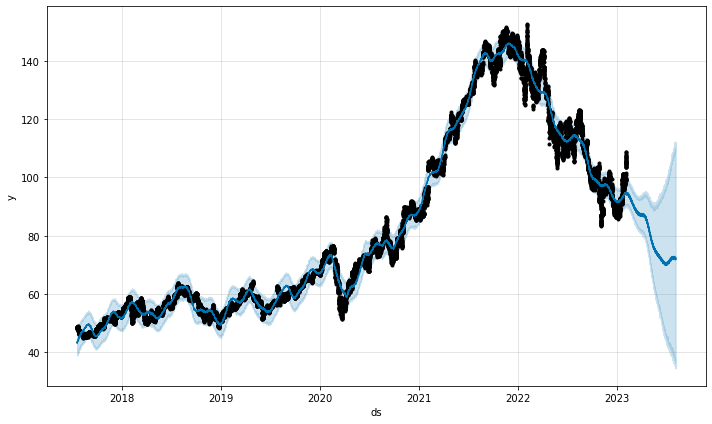

In [212]:
prophet_two.plot(six_month_predictions);